# Imports\


TODO:
1) check value/vat/no vat
2) check headlines, fix it


In [1]:
# !export GPN_DB_HOST=192.168.10.36


In [2]:
#!ls -la ../../work
# #!mv ../../../documents.json.zip ../../work
# # !unzip '../../work/documents.json.zip' '../../work/documents.json'
# !mv documents.json ../../work

In [3]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [4]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print("tf",tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')



2023-02-06 11:12:44.833756: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
DEBUG - 2023-02-06 11:12:46,367 - retrain_ipynb - --=logging started=--


tf 2.5.0
Running on CPU:x86_64


In [5]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
import analyser.hyperparams 

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')



### Imports...

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

from datetime import datetime
from math import log1p
from pandas import DataFrame
from analyser.persistence import DbJsonDoc
from colab_support.renderer import plot_embedding

from analyser.structures import DocumentState

from pathlib import Path
from bson import ObjectId

from datetime import date
from dateutil.relativedelta import relativedelta

# from tf_support.super_contract_model import seq_labels_contract, seq_labels_contract_swap_orgs
# 


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None
[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None
[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle
[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


### Prepare workdir

In [7]:
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /root/artem/work


### Query DB for contact IDs

#### Load meta data CSV

In [8]:
!touch /root/artem/work/contract_trainset_meta.temp.csv

In [9]:
# stats[["user_correction_date", 'analyze_date']].max().max()

In [10]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
        
    if not 'documentType' in stats:
        stats['documentType'] = 'Unknown'
    
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=True)
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=True)

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    print(f'ERROR: cannot load {export_fn}')
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(f'lastdate={lastdate} ; export_fn={export_fn}')
stats['source'] = 'db'
stats

lastdate=2023-02-04 11:02:49.897000+00:00 ; export_fn=/root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63dccb422c90db0b7a62aaa0,db,0fd8c821da37f3fa8e44c53767fb7842,23.01.23,2023-02-05 13:09:27.251321,1398.0,2023-02-03 12:45:55.389000+00:00,NaN,NaN,NaN,рублей,...,Займодавец,ИТО,Заемщик,Loans,0.811065,NaT,True,CONTRACT,84.0,12.0
63dccb3f2c90db0b7a62aa4f,db,63eb26415678c8e225543264d981d460,23.01.23,2023-02-05 13:09:27.298668,422.0,2023-02-03 12:46:57.294000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961689,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,2.0
63dccb3f2c90db0b7a62aa5d,db,5b8260ef4f47dfb261a3ee74193fc576,23.01.23,2023-02-05 13:09:27.304058,432.0,2023-02-03 12:47:14.155000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Канарейка,NaN,Other,0.961693,NaT,True,SUPPLEMENTARY_AGREEMENT,1.0,3.0
63dccb402c90db0b7a62aa77,db,94bb8a85bfb0d2168a144ec23aa7e99b,23.01.23,2023-02-05 13:09:27.313468,360.0,2023-02-03 12:47:53.920000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Союз,Заемщик,Other,0.857242,NaT,False,SUPPLEMENTARY_AGREEMENT,1.0,1.0


# functions

In [11]:

def get_amount(attr_tree):
  _value_tag = attr_tree.get('price')
  amount = None
  if _value_tag is not None:
    amount = _value_tag.get('amount_netto')
    if amount is None:
      amount = _value_tag.get('amount_brutto')
    if amount is None:
      amount = _value_tag.get('amount')
  return amount

        
    
def add_stats_record(d: DbJsonDoc, stats: DataFrame, source='db'):
  _id = str(d.get_id())
    
  attr_tree = d.get_attributes_tree()
 

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  stats.at[_id, 'version'] = d.get_version_string()
  stats.at[_id, 'documentType'] = d.documentType
    
 
  stats.at[_id, 'source'] = source
  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = pd.to_datetime( d.analysis['analyze_timestamp'] , utc=True)


  n_headers = len(d.analysis.get('headers', []))
  stats.at[_id, 'headers'] = n_headers
    
  _value_tag = attr_tree.get('price')
  
  if _value_tag is not None:
    amount = get_amount(attr_tree) 
    if amount:
        
        stats.at[_id, 'value'] = amount.get('value') 
        stats.at[_id, 'value_log1p'] = log1p(amount.get('value') )
        stats.at[_id, 'value_span'] = amount.get('span', [0,0]) [0]
#         print( stats.at[_id, 'value'])
    
    stats.at[_id, 'currency'] = _value_tag.get('currency', {}).get('value')
  
  _orgs = attr_tree.get('orgs', [{},{}]) 
  if len(_orgs)>0:
      stats.at[_id, 'org-1-name'] = _orgs[0].get('name', {}).get('value')
      stats.at[_id, 'org-1-alias'] = _orgs[0].get('alias', {}).get('value')

      if len(_orgs)>1:
        stats.at[_id, 'org-2-name'] = _orgs[1].get('name', {}).get('value')
        stats.at[_id, 'org-2-alias'] = _orgs[1].get('alias', {}).get('value')

  stats.at[_id, 'subject'] = attr_tree.get('subject', {}).get('value')
  stats.at[_id, 'subject confidence'] = attr_tree.get('subject', {}).get('confidence')
    

  span = attr_tree.get('subject', {}).get('span',[0,0])
  subject_len = span[1] - span[0]
  stats.at[_id, 'subj_len'] = subject_len  

  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = pd.to_datetime(d.user[ 'updateDate'], utc=True)
    

    # find_in_dict('attributes_tree.creation_date', d.user)

  valid_state = (DocumentState.Excluded.value==d.state or DocumentState.Done.value==d.state)
  if not valid_state:
    print(_id, 'invalid state: ', d.state)
  valid_struct = ('contract' in jd.analysis['attributes_tree'])
  if not valid_struct:
    print(_id, 'invalid structure: ', d.state)
  stats.at[_id, 'valid'] = valid_state and valid_struct and subject_len>0 and subject_len<=300 and n_headers>0


  


d = get_doc_by_id(ObjectId('5fe34f62b770574a005553be'))
jd = DbJsonDoc(d)
add_stats_record(jd, stats)
stats.loc['5fe34f62b770574a005553be']

DB HOST IS: 192.168.10.36


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_USER environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_PASSWORD environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_USE_MONGO_TLS environment variable! defaulting to False
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_CA environment variable! defaulting to None
  warnings.warn(msg)
/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_TLS_KEY environment varia

source                                                db
checksum                da2dd54cdcc5b4480207c9def7741d14
version                                           2.3.13
export_date                   2023-02-06 11:12:49.661607
len                                                  759
analyze_date            2020-12-23 17:14:16.727000+00:00
value                                           1.64e+06
value_log1p                                      14.3102
value_span                                           128
currency                                             RUB
org-1-name                        Газпромнефть-Снабжение
org-1-alias                               Благотворитель
org-2-name                           инициатив «Эпсилон»
org-2-alias                              Благополучатель
subject                                          Charity
subject confidence                                     1
user_correction_date    2022-12-08 19:07:01.522000+00:00
valid                          

# load old json

In [12]:
import json
import re
from bson import json_util

_DEBUG = False
file_data=None

try:
    fn = work_dir / 'documents.json'
    with open(fn) as file:
        file_data = json.load(file, object_hook=json_util.object_hook)

        print(f'total docs in {fn} is {len(file_data)}')    
        _DEBUG = True
except Exception as ex:
    logger.exception(ex)    




if _DEBUG:
    a_doc_from_json=DbJsonDoc(file_data[3])

    print(a_doc_from_json.get_attributes_tree())
    print(a_doc_from_json.get_version_string())

total docs in /root/artem/work/documents.json is 622
{'orgs': [{'type': {'span': [47, 48], 'span_map': 'words', 'confidence': 0.49801500000000004, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [49, 50], 'span_map': 'words', 'confidence': 0.9755, 'value': 'Газпромнефть-Сахалин'}, 'alias': {'span': [56, 57], 'span_map': 'words', 'confidence': 0.972, 'value': 'Арендатор'}}, {'type': {'span': [17, 18], 'span_map': 'words', 'confidence': 0.505665, 'value': 'Общество с ограниченной ответственностью'}, 'name': {'span': [19, 20], 'span_map': 'words', 'confidence': 0.9905, 'value': 'ЭКРУСС'}, 'alias': {'span': [26, 27], 'span_map': 'words', 'confidence': 0.987, 'value': 'Арендодатель'}}], 'date': {'span': [9, 14], 'span_map': 'words', 'confidence': 1, 'value': datetime.datetime(2016, 5, 10, 0, 0, tzinfo=<bson.tz_util.FixedOffset object at 0x7f2f48c17d90>)}, 'number': {'span': [1, 4], 'span_map': 'words', 'confidence': 1, 'value': 'RP 16-06'}, 'subject': {'span': [100, 1

semantic_map_keys ['amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit']
semantic_map_keys ['org-name', 'org-alias', 'org-type']
semantic_map_keys all ['headline', 'subject', 'date', 'number', 'org-name', 'org-alias', 'org-type', 'amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']
semantic_map_keys_contract ['headline-begin', 'headline-end', 'subject-begin', 'subject-end', 'date-begin', 'date-end', 'number-begin', 'number-end', 'org-name-begin', 'org-name-end', 'org-alias-begin', 'org-alias-end', 'org-type-begin', 'org-type-end', 'amount-begin', 'amount-end', 'amount_brutto-begin', 'amount_brutto-end', 'amount_netto-begin', 'amount_netto-end', 'vat-begin', 'vat-end', 'sign-begin', 'sign-end', 'currency-begin', 'currency-end', 'vat_unit-begin', 'vat_unit-end', 'value-begin', 'value-end']


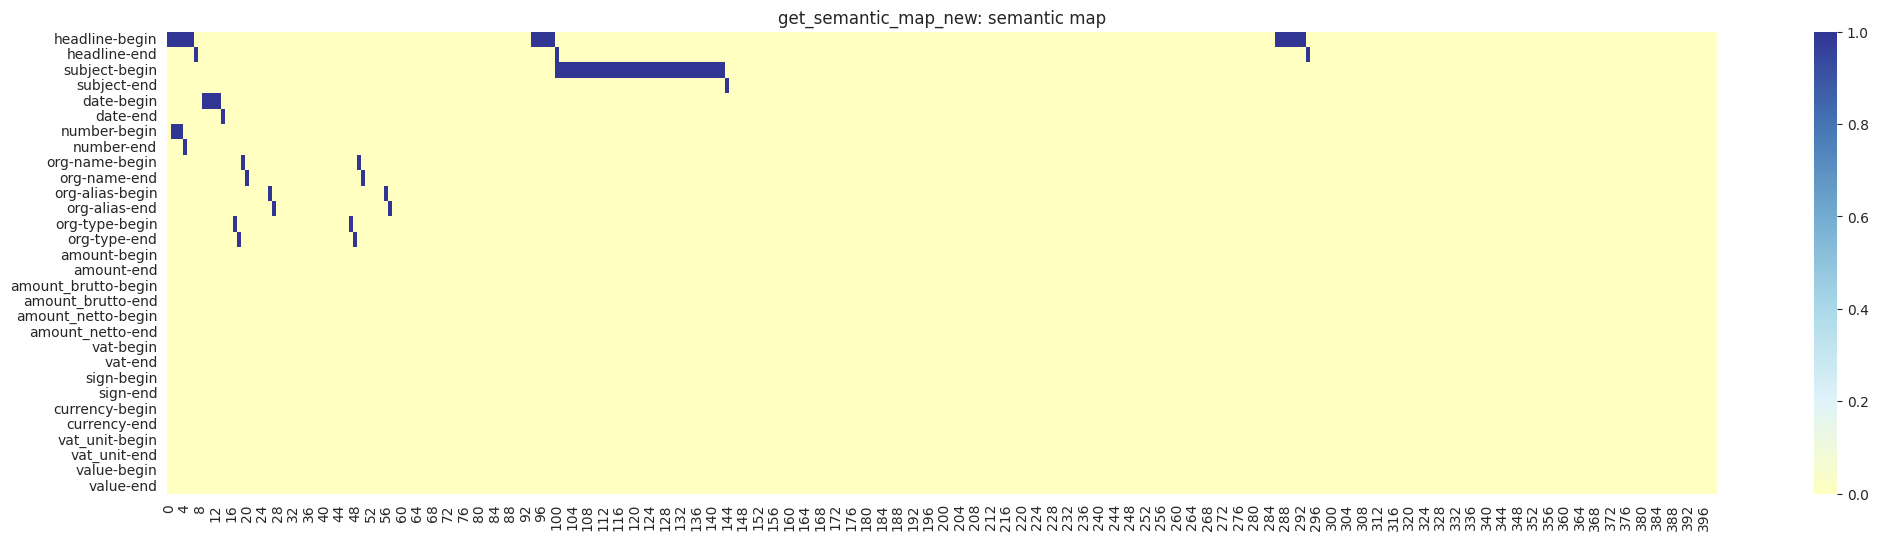

1.0
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
3148    0.0
3149    0.0
3150    0.0
3151    0.0
3152    0.0
Name: date-begin, Length: 3153, dtype: float64


In [13]:


semantic_map_keys = [
    'headline',
    'subject', 
    'date', 
    'number',
    'org-name', 
    'org-alias', 
    'org-type'
]

semantic_map_keys += ['amount', 'amount_brutto', 'amount_netto', 'vat', 'sign', 'currency', 'vat_unit', 'value']

semantic_map_keys_contract = []
for _name in semantic_map_keys:
    semantic_map_keys_contract.append(_name + "-begin")
    semantic_map_keys_contract.append(_name + "-end")

print("semantic_map_keys", semantic_map_keys[8:14])
print("semantic_map_keys", semantic_map_keys[4:7])
print("semantic_map_keys all", semantic_map_keys)
print("semantic_map_keys_contract", semantic_map_keys_contract)

def get_semantic_map_new(doc: DbJsonDoc):
    
    _len = len(doc)
    df = DataFrame()
    
    for sl in semantic_map_keys_contract:    
        df[sl] = np.zeros(_len)
    
    attr_tree = doc.get_attributes_tree()
    
    def get_av(name):
        if name in df:
            return df[name]
        else:
            av = np.zeros(_len, np.float)
            df[name] = av
            return av

            
    def add_span_vectors(_name, span):
#         print('add_span_vectors',span)
        bn = _name + "-begin"
        en = _name + "-end"
        b = get_av(bn)
        e = get_av(en)
        if not span is None:
            df[bn][ span[0]:span[1] ]=1.
            df[en][ span[1] ]=1.
 
        

    # Headers
    headers = doc.analysis['headers']
    for h in headers:
        add_span_vectors('headline', h['span'])
 
 
    for n in semantic_map_keys[1:4]:
        span = attr_tree.get(n, {}).get('span')
        add_span_vectors(n, span)

 
    for i in [1, 2]:
        for n in semantic_map_keys[4:7]:
            try:                
                _nm = n.replace('org-', f'')
                span = attr_tree['orgs'][i-1][_nm]['span']
                add_span_vectors(n, span)
            except Exception as e:
                logger.exception(e)
                print('ERROR (sp)', e, i, n,  _nm)
                if _DEBUG:
                    try:  
                        print(json.dumps( attr_tree['orgs'][i-1], sort_keys=True, indent=4))
                    except:
                        pass
                    print('ERROR', i, n, doc.get_id(), e, attr_tree.get('orgs', None))
 

    _value_tag = attr_tree.get('price', {})
    add_span_vectors("value", _value_tag.get('span'))
 
    if _value_tag is not None:
        amount = get_amount(attr_tree) 
        if amount:
            add_span_vectors('amount', amount.get('span'))
        for n in semantic_map_keys[8:14]:
            add_span_vectors(n, _value_tag.get(n,{}).get('span'))
           
    return df[semantic_map_keys_contract]



if _DEBUG:
    sm_test = get_semantic_map_new(a_doc_from_json)
    plot_embedding(sm_test[0:400], f'get_semantic_map_new: semantic map')
    print(sm_test['date-begin'].max())
    print(sm_test['date-begin'])

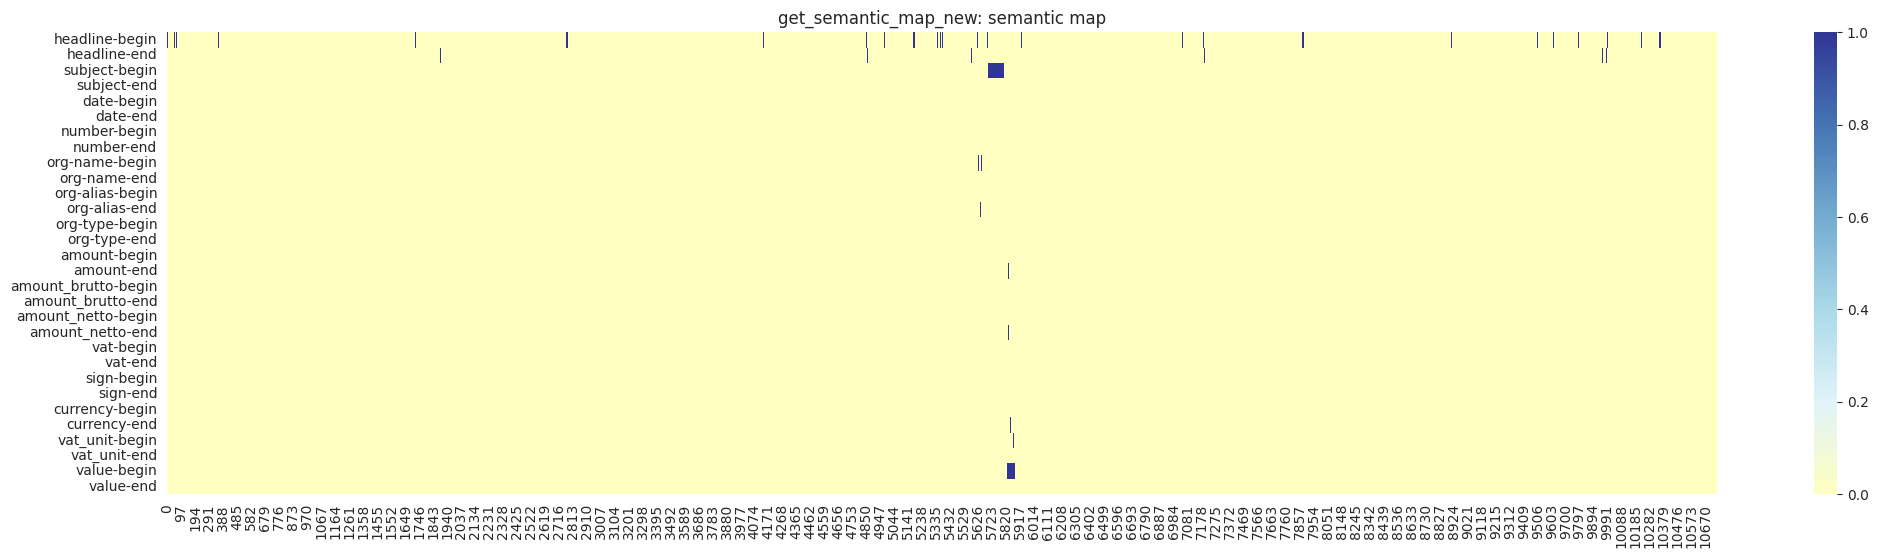

In [14]:
#test one

d = get_doc_by_id(ObjectId('636dfd1473925c8dae26f910'))
if d is not None:
    jd = DbJsonDoc(d)
    semantic_map: DataFrame = get_semantic_map_new(jd)


    plot_embedding(semantic_map, f'get_semantic_map_new: semantic map')

### Adding data from old json file to the stats table

In [15]:
# fff
files_dict = {}

if file_data:
    k=0
    for d in file_data:
        k+=1 
        jd = DbJsonDoc(d)
    #     print( jd.analysis['analyze_timestamp'])
        files_dict[jd.get_id()] = jd
        try:            
            add_stats_record(jd, stats, source = 'file')
        except Exception as e:
            print(e)
            print(jd.get_id())
#             raise (e)

        if k % 100 == 0:
#             stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'], utc=False)
#             stats['analyze_date'] = pd.to_datetime(stats['analyze_date'], utc=False)
#             stats['export_date'] = pd.to_datetime(stats['export_date'], utc=False)
            
    
            print(f'{k} of {len(file_data)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')

            
            
stats.to_csv(export_fn, index=True)
stats.to_csv('tmp.csv', index=True)

print(f'stats saved to {export_fn}')

# del file_data
stats




100 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
200 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
300 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
400 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv

5efdb73b777d4b67a92d533c
500 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
600 of 622
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.0,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.0,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.0,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.0,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.0,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-06 11:13:04.589817,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-06 11:13:12.965704,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Заказчик,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-06 11:13:14.194385,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-06 11:13:14.477587,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0


In [16]:
# stats = stats.drop('63c506afe2456d59975e0fcd')
stats[stats.index.duplicated()]



,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers


In [17]:
invalid = stats[stats['valid']==False]
print(f'{len(invalid)}: number of invalid records')
invalid

134: number of invalid records


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
62947a20df54d406a99b15b1,db,e0a4a3a2aefe5867844d1821febdcbd1,3.0.0,2023-01-31 18:20:55.958989,645.0,2022-05-30 11:04:02.908000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.833751,NaT,False,ANNEX,0.0,6.0
62948c5cdf54d406a99b15c6,db,d1a0c7ae08a3c1a32419d1686c001eff,3.0.0,2023-01-31 18:20:55.965194,249.0,2022-05-30 12:21:20.439000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.981159,NaT,False,ANNEX,0.0,3.0
629f4c5841f3e78db0acc603,db,2b4fc710def608f726016b949c86ec86,3.0.0,2023-01-31 18:20:56.506256,207.0,2022-06-07 16:04:20.632000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.982557,NaT,False,ANNEX,0.0,4.0
62a99d94326a4191e5f17392,db,434d150b1e1996e94e81bd882d899df9,3.0.0,2023-01-31 18:20:56.671357,323.0,2022-06-15 11:59:11.578000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.986055,NaT,False,ANNEX,0.0,3.0
62b0742efe720621f7ce44a3,db,67f3089b0b87c8543990a412fb16d370,3.0.0,2023-01-31 18:20:57.913462,312.0,2022-06-20 16:22:30.360000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Other,0.912277,NaT,False,ANNEX,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ee188952281f29204c522dc,file,520bf70b9df1ee9ee999fe870d936a51,1.11.2,2023-02-06 11:13:04.589817,7298.0,2020-06-12 22:43:06.038000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,2020-06-11 08:49:53.635000+00:00,False,CONTRACT,0.0,4.0
5efe9252777d4b67a92d5621,file,ed9385088ed6d9c967a9b68a8d10ecc2,2.0.0,2023-02-06 11:13:12.965704,19504.0,2020-07-03 16:50:25.668000+00:00,65300168.0,17.994505,7412.0,RUB,...,Заказчик,Шлюмберже Лоджелко Инк.,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,26.0
5efe9280777d4b67a92d56ce,file,02a4101c17ceaa4b9d473f6840ac4d7a,2.0.0,2023-02-06 11:13:14.194385,14025.0,2020-07-03 21:47:22.279000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,NaN,NaT,False,CONTRACT,0.0,2.0
5efe9288777d4b67a92d56d3,file,33f326573547c95e1d381eecd79136a2,2.0.0,2023-02-06 11:13:14.477587,19219.0,2020-07-03 21:15:51.170000+00:00,NaN,NaN,NaN,NaN,...,Заказчик,Газпромнефть-Сахалин,Исполнитель,None,NaN,NaT,False,CONTRACT,0.0,25.0


In [18]:
# !tail /root/artem/work/contract_trainset_meta.temp.csv

# Fetch fresh docs from Mongo DB

In [19]:


# if True:
lastdate = lastdate + relativedelta(days=-5)
#     lastdate = datetime.combine(lastdate, datetime.min.time())

lastdate = pd.to_datetime( lastdate , utc=True)
lastdate

Timestamp('2023-01-30 11:02:49.897000+0000', tz='UTC')

In [20]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },
      
#     {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего новых документов после 2023-01-30 11:02:49.897000+00:00 : 182

[{'_id': ObjectId('5ec2b8d8665f7603e03b122b'),
  'parse': {'documentType': 'CONTRACT'},
  'state': 12,
  'user': {'updateDate': datetime.datetime(2023, 2, 2, 14, 26, 8, 111000)}},
 {'_id': ObjectId('5fb278c1d8c9df1ed1236d47'),
  'user': {'updateDate': datetime.datetime(2023, 2, 2, 14, 19, 22, 231000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}},
 {'_id': ObjectId('5fb399dd39d5e82e90818477'),
  'user': {'updateDate': datetime.datetime(2023, 2, 4, 8, 18, 39, 335000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}},
 {'_id': ObjectId('5fbbe467a2b4551c06107b06'),
  'user': {'updateDate': datetime.datetime(2023, 2, 3, 13, 14, 25, 102000)},
  'state': 15,
  'parse': {'documentType': 'CONTRACT'}}]

# Prepare training set

In [21]:
new_docs_ids = docs_ids = [i["_id"] for i in res]
print(len(new_docs_ids))
# sample_id = ObjectId('637f7bf0e712cc2ff2e943d3')

# sample_id = docs_ids[1]
# sample_id
# d = get_doc_by_id(sample_id)

# jd = DbJsonDoc(d)
# jd.get_id()
# print(d['_id'])


#==========================Test 1 doc
    
# print(jd.get_version_string())
 
# add_stats_record(jd, stats)
# stats.loc[str(jd._id)]
 

182


In [22]:
new_docs_ids

[ObjectId('5ec2b8d8665f7603e03b122b'),
 ObjectId('5fb278c1d8c9df1ed1236d47'),
 ObjectId('5fb399dd39d5e82e90818477'),
 ObjectId('5fbbe467a2b4551c06107b06'),
 ObjectId('5fbf668c5d05d73d0295fa46'),
 ObjectId('5fbf75af5d05d73d0295fa96'),
 ObjectId('5fbf75ae5d05d73d0295fa82'),
 ObjectId('5fbf75ad5d05d73d0295fa6b'),
 ObjectId('5fbf75af5d05d73d0295faa0'),
 ObjectId('5fc5eb6b1d0a1603c7a0c8b2'),
 ObjectId('5fbbe46aa2b4551c06107ba5'),
 ObjectId('5fca2aab9083b679224c75e7'),
 ObjectId('5fca2aac9083b679224c75f7'),
 ObjectId('5fca2aab9083b679224c75ea'),
 ObjectId('5fca2aac9083b679224c7600'),
 ObjectId('5fca2aac9083b679224c75f6'),
 ObjectId('5fca2ab09083b679224c7639'),
 ObjectId('5fca2ab39083b679224c7655'),
 ObjectId('5fca2ab49083b679224c7659'),
 ObjectId('5fca2ab09083b679224c762f'),
 ObjectId('5fc6452a1d0a1603c7a0c9e8'),
 ObjectId('5fdb2141542ce403c92b4576'),
 ObjectId('5fc63d611d0a1603c7a0c96b'),
 ObjectId('5fc7a038c54bc33809e2621d'),
 ObjectId('5fc7a036c54bc33809e261f7'),
 ObjectId('5fc7a037c54bc3

In [23]:
# plot_embedding(get_semantic_map_new(jd)[:300], f'semantic map')
# print(len(docs_ids))

In [24]:
def add_to_stats_list(docs_ids):
    for k, oid in enumerate(docs_ids):
        d = get_doc_by_id(ObjectId(str(oid)))
        try:
            jd = DbJsonDoc(d)
            add_stats_record(jd, stats)
        except Exception as e:
            print(oid)
            print (e)

        if k % 100 == 0:
            print(f'{k} of {len(docs_ids)}')
            stats.to_csv(export_fn, index=True)
            print(f'stats saved to {export_fn}')
        
add_to_stats_list(docs_ids)        
stats.to_csv(export_fn, index=True)
print(f'stats saved to {export_fn}')
stats

0 of 182
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
100 of 182
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
stats saved to /root/artem/work/contract_trainset_meta.temp.csv


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,ГПН,SUN,SUN,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2.970000e+03,7.996654,1364.0,RUB,...,Покупатель,Иідате. тьско-ііо. тиі рафнческое предприятие ...,Поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,9.000000e+04,11.407576,1834.0,RUB,...,Арендатор,"Фонд исследований, инноваций, инвестиций Тюмен...",Арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,Принципал,Газпромнефть-Снабжение,Агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,1.548241e+07,16.555215,699.0,RUB,...,Агент,ГазРромнефть-ГЕО,Принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63dccb422c90db0b7a62aab1,db,f31c50b18a70c7d3c76739d3f3a75883,23.01.23,2023-02-06 11:13:22.924804,289.0,2023-02-03 12:48:21.573000+00:00,NaN,NaN,NaN,NaN,...,Займодавец,Союз,Заемщик,None,NaN,2023-02-03 15:01:21.016000+00:00,False,SUPPLEMENTARY_AGREEMENT,0.0,1.0
63dccb3a2c90db0b7a62aa13,db,eecf932911e62f5c54ca4cb17d52e000,23.01.23,2023-02-06 11:13:22.929096,661.0,2023-02-03 18:02:04.250000+00:00,1.000000e+08,18.420681,290.0,None,...,Гарант,None,Бенефициар,Charity,0.211541,NaT,False,CONTRACT,0.0,2.0
63dccb3c2c90db0b7a62aa21,db,eecf932911e62f5c54ca4cb17d52e000,23.01.23,2023-02-06 11:13:22.933407,661.0,2023-02-03 18:02:06.033000+00:00,1.000000e+08,18.420681,290.0,None,...,Гарант,None,Бенефициар,Charity,0.211541,NaT,False,CONTRACT,0.0,2.0
62862adb4d1bfe5e5b297dee,db,c81664bbc202b2a143fe57dfcb950348,23.01.23,2023-02-06 11:13:23.503476,25014.0,2023-02-04 11:20:30.480000+00:00,3.050000e+09,21.838407,14195.0,RUB,...,Заказчик,Астра,Подрядчик,Service,0.514836,NaT,False,SUPPLEMENTARY_AGREEMENT,0.0,22.0


In [25]:
# _ids = list(
#     stats[stats['source']=='db']
#     [stats['documentType']=='undefined'][ stats['user_correction_date'].notna()].index)


# add_to_stats_list(_ids)        
# stats.to_csv(export_fn, index=True)

s = stats[ stats['source']=='db'] 
# s = s[s['documentType']=='CONTRACT']
# s = s[s['subj_len'].isna()]
# s = s[s['user_correction_date'].notna()]
# s = s[s['value']>0]
_ids = list(s[s['headers'].isna()].index)
print(len(_ids))
add_to_stats_list(_ids)     
print(f'saving to {export_fn}; {len(stats)} records')
stats.to_csv(export_fn, index=True)

13
637397e2a8eb8dc64b37543b
'NoneType' object is not iterable
0 of 13
stats saved to /root/artem/work/contract_trainset_meta.temp.csv
637397e2a8eb8dc64b37543c
'NoneType' object is not iterable
637397e2a8eb8dc64b37543d
'NoneType' object is not iterable
637397e2a8eb8dc64b37543f
'NoneType' object is not iterable
637397e2a8eb8dc64b375440
'NoneType' object is not iterable
637397e2a8eb8dc64b375441
'NoneType' object is not iterable
637397e2a8eb8dc64b37543a
'NoneType' object is not iterable
637397e2a8eb8dc64b37543e
'NoneType' object is not iterable
637e11d66a07f3e980b2bfbf
'NoneType' object is not iterable
637e11d76a07f3e980b2bfc0
'NoneType' object is not iterable
637f2826fe09513dc6b2bfbf
'NoneType' object is not iterable
637f2826fe09513dc6b2bfc0
'NoneType' object is not iterable
637f725ec15a83c52bb2bfc1
'NoneType' object is not iterable
saving to /root/artem/work/contract_trainset_meta.temp.csv; 6757 records


/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [26]:
stats = stats[stats.valid!=False]
len(stats)

6539

In [27]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,org-1-alias,org-2-name,org-2-alias,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,25236322.0,17.043795,5674.0,BRL,...,гпн,sun,sun,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0
5fb376e2d8c9df1ed123726c,db,f7c027bb799a50d6fda9d32443bb9cdd,2.0.5,2023-01-31 18:32:26.281114,2794.0,2020-11-17 07:11:23.321000+00:00,2970.0,7.996654,1364.0,RUB,...,покупатель,иідате. тьско-ііо. тиі рафнческое предприятие ...,поставщик,Deal,1.000000,2022-12-08 12:28:06.617000+00:00,True,CONTRACT,82.0,17.0
5fb399dc39d5e82e90818474,db,375f811ae7c0edcc737d7342373710cb,2.0.5,2023-01-31 18:32:26.380129,3742.0,2020-11-17 09:56:11.605000+00:00,90000.0,11.407576,1834.0,RUB,...,арендатор,"фонд исследований, инноваций, инвестиций тюмен...",арендодатель,Renting,1.000000,2022-12-07 08:14:03.960000+00:00,True,CONTRACT,97.0,13.0
5fb3b97d00881c332b567292,db,5f4482e55f27e0fcb20b1ffd819d0260,2.0.5,2023-01-31 18:35:58.018598,2248.0,2020-11-17 12:01:39.924000+00:00,NaN,NaN,NaN,NaN,...,принципал,газпромнефть-снабжение,агент,AgencyContract,1.000000,2022-12-08 11:25:15.676000+00:00,True,CONTRACT,86.0,15.0
5fb3b97e00881c332b5672bd,db,eb69b91855f471b6db8deb924eb34aa5,2.0.5,2023-01-31 18:32:26.391339,3546.0,2020-11-17 12:12:00.629000+00:00,15482412.0,16.555215,699.0,RUB,...,агент,газрромнефть-гео,принципал,AgencyContract,1.000000,2022-12-08 19:01:33.745000+00:00,True,CONTRACT,55.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63dccb422c90db0b7a62aaa0,db,0fd8c821da37f3fa8e44c53767fb7842,23.01.23,2023-02-06 11:13:22.841404,1398.0,2023-02-03 12:45:55.389000+00:00,NaN,NaN,NaN,рублей,...,займодавец,ито,заемщик,Loans,0.811065,NaT,True,CONTRACT,84.0,12.0
63dccb3f2c90db0b7a62aa4f,db,63eb26415678c8e225543264d981d460,23.01.23,2023-02-06 11:13:22.889946,422.0,2023-02-03 12:46:57.294000+00:00,NaN,NaN,NaN,NaN,...,займодавец,канарейка,None,Other,0.961689,NaT,True,SUPPLEMENTARY_AGREEMENT,1.0,2.0
63dccb3f2c90db0b7a62aa5d,db,5b8260ef4f47dfb261a3ee74193fc576,23.01.23,2023-02-06 11:13:22.895283,432.0,2023-02-03 12:47:14.155000+00:00,NaN,NaN,NaN,NaN,...,займодавец,канарейка,None,Other,0.961693,NaT,True,SUPPLEMENTARY_AGREEMENT,1.0,3.0
63dccb402c90db0b7a62aa77,db,94bb8a85bfb0d2168a144ec23aa7e99b,23.01.23,2023-02-06 11:13:22.904573,360.0,2023-02-03 12:47:53.920000+00:00,NaN,NaN,NaN,NaN,...,займодавец,союз,заемщик,Other,0.857242,NaT,True,SUPPLEMENTARY_AGREEMENT,1.0,1.0


In [28]:
stats2['subject'].value_counts()

Other                                2572
Service                              2091
Deal                                  497
Renting                               199
Loans                                 193
GeneralContract                       181
AgencyContract                         94
DealIntellectualProperty               88
Charity                                82
Insurance                              60
RealEstate                             37
ParticipationInOtherOrganizations      24
RealEstateTransactions                 21
PledgeEncumbrance                      20
BankGuarantees                         14
SecuritiesTransactions                 11
EmployeeContracts                       2
BigDeal                                 2
AssetTransactions                       1
DealGeneralBusiness                     1
Name: subject, dtype: int64

In [29]:
stats2['org-1-alias'].value_counts()

заказчик           1500
исполнитель         616
покупатель          351
поставщик           155
продавец            137
                   ... 
благополучатель       1
унисит                1
регистратор           1
тзк                   1
промкатализ           1
Name: org-1-alias, Length: 95, dtype: int64

In [30]:
stats2['org-2-alias'].value_counts()

исполнитель         1218
заказчик             655
поставщик            295
покупатель           266
подрядчик            252
                    ... 
весна                  1
благотворитель         1
правительство          1
брокер                 1
налогоплательщик       1
Name: org-2-alias, Length: 98, dtype: int64

In [31]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1.):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
print(len(stats2))
stats2.head(40)

6539


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score
6340244c9d08c565cfa12341,db,bc7d70a32aed6af4ef6c7752a1b7674d,3.0.0,2023-01-31 18:37:33.526517,6747.0,2022-10-07 16:09:15.340000+00:00,2.000000e+09,21.416413,909.0,RUB,...,Loans,1.000000,2022-10-07 13:43:21.470000+00:00,True,AGREEMENT,130.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6340...,False,0.354535
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5847.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,Service,1.000000,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,0.646596
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-06 11:13:01.260685,1373.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,AgencyContract,0.646182,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,0.650790
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-06 11:12:57.718593,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,Charity,0.000000,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,0.759703
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8535.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,Loans,1.000000,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.155858
63908ca4a1bded13e629f2eb,db,3bc04887446d02692e886db2545bba61,22.12.7,2023-01-31 18:38:08.500901,13410.0,2022-12-08 13:59:29.898000+00:00,2.000000e+10,23.718998,2572.0,RUB,...,BankGuarantees,1.000000,2022-12-08 11:04:21.263000+00:00,True,AGREEMENT,84.0,21.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6390...,False,1.645631
6391b4771864c6df4d29f332,db,22f701119d81787cd423f79f0f9fd9db,22.12.7,2023-02-06 11:13:20.612545,1990.0,2022-12-08 22:25:50.608000+00:00,1.000000e+11,25.328436,483.0,RUB,...,BankGuarantees,1.000000,2023-02-04 08:03:42.003000+00:00,True,CONTRACT,151.0,8.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6391...,False,1.651265
633fd0a69d08c565cfa1232a,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:54.225685,5556.0,2022-10-07 10:10:07.028000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,SecuritiesTransactions,1.000000,2023-01-27 11:36:12.388000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/633f...,False,1.692323
6285f9c04d1bfe5e5b297ddd,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-02-01 17:26:53.153480,5556.0,2022-05-19 11:03:36.611000+00:00,1.000000e+11,25.328436,1505.0,RUB,...,SecuritiesTransactions,1.000000,2023-01-27 11:32:42.657000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,False,1.692323
6246a3fa25a983726c7694af,db,61cfee32867b371843d1e95a194ea2a6,3.0.0,2023-01-31 18:32:42.511519,5556.0,2022-04-01 10:21:21.897000+00:00,1.000000e+11,25.328436,1505.0,NaN,...,SecuritiesTransactions,1.000000,2022-04-01 07:27:01.064000+00:00,True,CONTRACT,37.0,17.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6246...,False,1.692323


In [32]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [33]:
stats2['len'] //= 10 #similar lens
stats2['len'] *= 10 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score
5fc7a047c54bc33809e26372,db,82137d4b0ded9b81b1d12f4d9e98c383,2.0.5,2023-01-31 18:21:21.813526,49340.0,2020-12-03 08:07:48.699000+00:00,90619807.0,18.322183,4503.0,RUB,...,Service,0.896091,NaT,True,CONTRACT,44.0,53.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc7...,True,3.662516e+03
5fca2acd9083b679224c77da,db,6b64d52e5ecb4941696164ed4950e735,2.0.5,2023-01-31 18:21:28.019257,49040.0,2020-12-10 10:40:36.652000+00:00,90619807.0,18.322183,4207.0,RUB,...,GeneralContract,1.000000,2021-07-30 21:59:37.858000+00:00,True,CONTRACT,44.0,44.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fca...,False,3.448430e+01
5fb3b9a800881c332b567433,db,287d93101b752b5f041d476d7196864e,2.0.5,2023-01-31 18:21:09.911469,44180.0,2020-11-17 11:54:59.086000+00:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaT,True,CONTRACT,0.0,52.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08
5f09a55a138e9184feef1f3d,file,1a9db8f1670e2e976b777841a0cd3412,2.0.4,2023-02-06 11:13:16.090214,39860.0,2020-10-04 10:50:52.531000+00:00,NaN,NaN,NaN,NaN,...,Service,1.000000,2020-10-04 02:48:25.763000+00:00,True,CONTRACT,118.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,False,1.907898e+05
5f09c1c7138e9184feef1f69,file,1a9db8f1670e2e976b777841a0cd3412,2.0.1,2023-02-06 11:13:17.487559,39860.0,2020-07-11 21:43:23.938000+00:00,NaN,NaN,NaN,NaN,...,Service,0.998361,NaT,True,CONTRACT,118.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5f09...,True,3.815796e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638f0a7fb1363747e929f2ec,db,109407c8fd295cd3e3bf6c51ae8c8c4f,22.12.6,2023-01-31 18:38:07.384039,10.0,2022-12-06 12:27:52.306000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984498,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.481054e+07
638f0a7fb1363747e929f2f0,db,0cbc9c41015ca9671bab95c12d5760a4,22.12.6,2023-01-31 18:38:07.387106,10.0,2022-12-06 12:27:53.027000+00:00,NaN,NaN,NaN,NaN,...,Other,0.984397,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.481054e+07
638f0a7fb1363747e929f2ef,db,16bbfb78a184b3f37e6c9866aa4c94d9,22.12.6,2023-01-31 18:38:07.386171,10.0,2022-12-06 12:27:52.856000+00:00,NaN,NaN,NaN,NaN,...,Other,0.982682,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/638f...,True,8.481054e+07
63c506bde2456d59975e1112,db,0cbc9c41015ca9671bab95c12d5760a4,23.01.04,2023-01-31 18:38:08.881351,10.0,2023-01-16 11:36:53.287000+00:00,NaN,NaN,NaN,NaN,...,Other,0.974322,NaT,True,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,8.481054e+07


In [34]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])
print(len(stats2))
stats2

6539


,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,subject confidence,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash
5fc63d611d0a1603c7a0c97d,db,08a1ee1556c3a53d857945a3f718e245,2.0.5,2023-01-31 18:36:05.219186,710.0,2020-12-18 10:43:04.513000+00:00,NaN,NaN,NaN,NaN,...,1.000000,2020-12-18 07:42:51.215000+00:00,True,CONTRACT,72.0,6.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fc6...,False,1.373533e+04,-9.218992e+18
5fb6750a33c72547b7550105,db,ea90f51aca035518002bd3606c56defe,2.0.5,2023-01-31 18:32:31.776455,3050.0,2020-11-19 14:27:31.189000+00:00,4.930520e+05,13.108372,2005.0,RUB,...,0.997197,NaT,True,CONTRACT,67.0,13.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb6...,True,4.375251e+03,-9.211684e+18
5fbbbd19a2b4551c061079cc,db,ea90f51aca035518002bd3606c56defe,2.0.5,2023-01-31 18:32:32.564032,3050.0,2020-11-23 14:13:32.616000+00:00,4.930520e+05,13.108372,2005.0,RUB,...,0.997197,NaT,True,CONTRACT,67.0,13.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fbb...,True,4.375251e+03,-9.211684e+18
5fb3d7a478df3635f5441dd2,db,7d95a7e6eeb468ba57094eb3c6ec1cc7,2.0.5,2023-01-31 18:21:11.488553,2800.0,2020-11-17 16:05:35.675000+00:00,NaN,NaN,NaN,NaN,...,0.998400,NaT,True,CONTRACT,73.0,14.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.192090e+06,-9.211046e+18
5fe4821eb770574a00555722,db,7d95a7e6eeb468ba57094eb3c6ec1cc7,2.3.13,2023-01-31 18:36:06.222269,2800.0,2020-12-24 17:40:02.031000+00:00,NaN,NaN,NaN,NaN,...,1.000000,2021-07-22 14:43:55.954000+00:00,True,CONTRACT,73.0,14.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fe4...,False,5.960448e+04,-9.211046e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63c506e2e2456d59975e1500,db,63f6600e241fc8eb309690a49e0bb64e,23.01.04,2023-01-31 21:42:47.066704,4600.0,2023-01-16 14:26:48.614000+00:00,5.000000e+02,6.216606,243.0,RUB,...,0.995550,NaT,True,CONTRACT,59.0,19.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.606037e+06,9.200255e+18
63ce4b03e83d1ee490f4002f,db,95d0e4e41638a417c5bf8e1f3c93e095,23.01.23,2023-01-31 21:43:34.968513,6980.0,2023-01-26 05:00:47.109000+00:00,NaN,NaN,NaN,NaN,...,0.907453,NaT,True,CONTRACT,46.0,15.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,True,6.216718e+05,9.200898e+18
5fdb213d542ce403c92b4518,db,31604ed02e098d52c45b37a72f97f91d,2.0.5,2023-01-31 18:32:37.962601,1260.0,2020-12-17 16:29:42.386000+00:00,3.168000e+04,10.363472,543.0,RUB,...,1.000000,2020-12-17 11:58:16.345000+00:00,True,CONTRACT,83.0,11.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fdb...,False,9.223488e+01,9.216767e+18
5eea27b4c28b75807f3daf5d,file,a3bcc95df8316b8868735383b27447a5,2.0.1,2023-02-06 11:13:07.292805,6370.0,2020-07-11 15:47:09.013000+00:00,2.836434e+07,17.160643,2485.0,RUB,...,0.997723,NaT,True,CONTRACT,44.0,19.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5eea...,True,1.114030e+03,9.220527e+18


In [35]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

6539

### Drop duplicates

In [36]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
# dups_s = dups_s[dups_s[score_column_name] < 5000]
print(len(dups_s))

# dups_s [dups_s['len'] > 30000].head(40)

3119


## Remove rare subjects and very long docs

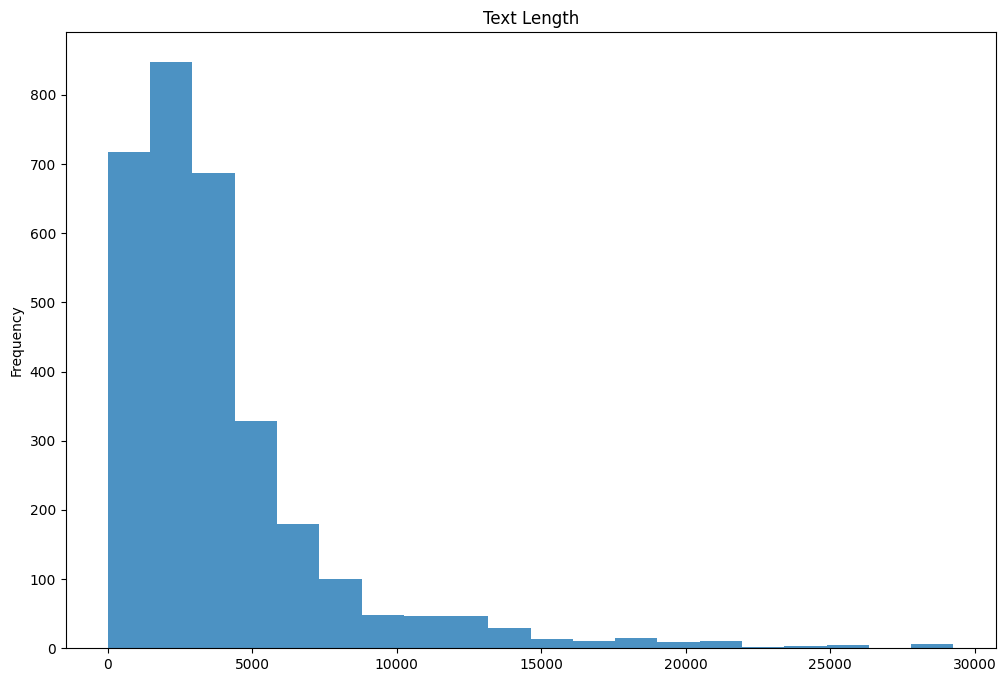

In [37]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=20, alpha=0.8)
ax.set_title('Text Length')
plt.show()

0.3545353268011222


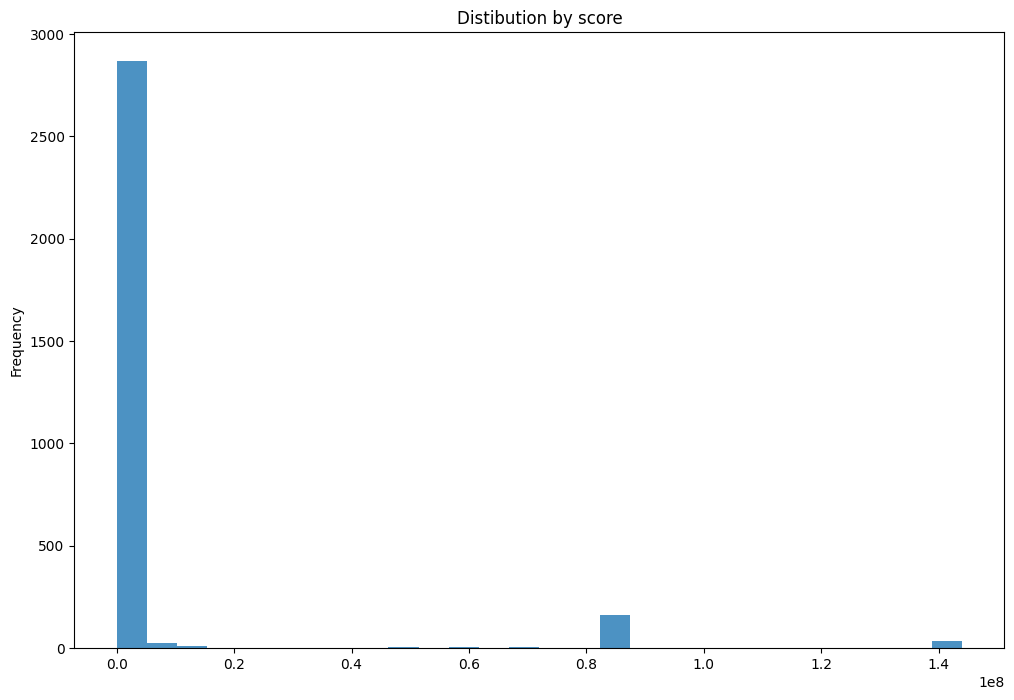

In [38]:
print(dups_s[score_column_name].min())
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=28, alpha=0.8)
ax.set_title('Distibution by score')
plt.show()

In [39]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len'] > 30000:
        print ('excluding', i, row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 3:
            print ('excluding', i, row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

excluding too long docs
excluding 5e58df7823869ee43538823d file GeneralContract 31090.0
excluding 5fbf75c75d05d73d0295fac0 db GeneralContract 38360.0
excluding 5fca2acd9083b679224c77da db GeneralContract 49040.0
excluding 5fca2ac79083b679224c774f db GeneralContract 39310.0
excluding 5f9672f182451803b5001df7 db GeneralContract 31170.0
excluding 5e5de70d01c6c73c19eebd4a file GeneralContract 31090.0
excluding 5fc7a047c54bc33809e26372 db Service 49340.0
excluding 5f09a55a138e9184feef1f3d file Service 39860.0
excluding 615e9e978f3b0514f3f42413 db Loans 35800.0
excluding 6246a2d525a983726c76949d db Other 35560.0
excluding 5fb3b9a800881c332b567433 db nan 44180.0
excluding docs with rare subj
excluding 5feb3e50bd24992aa31040df db AssetTransactions
excluding 5fb6750c33c72547b7550147 db BigDeal
excluding 638085866a07f3e980b2c441 db DealGeneralBusiness
excluding 5dee80604ddc27bcf92dd88e file EmployeeContracts
excluding 610d2b0d7dfce422c4272d39 db EmployeeContracts


Service                              1565
Other                                 429
Deal                                  364
Renting                               143
GeneralContract                       129
Loans                                 106
AgencyContract                         77
DealIntellectualProperty               65
Charity                                52
Insurance                              45
RealEstate                             32
RealEstateTransactions                 16
BankGuarantees                         13
PledgeEncumbrance                      12
ParticipationInOtherOrganizations      11
SecuritiesTransactions                  8
Name: subject, dtype: int64


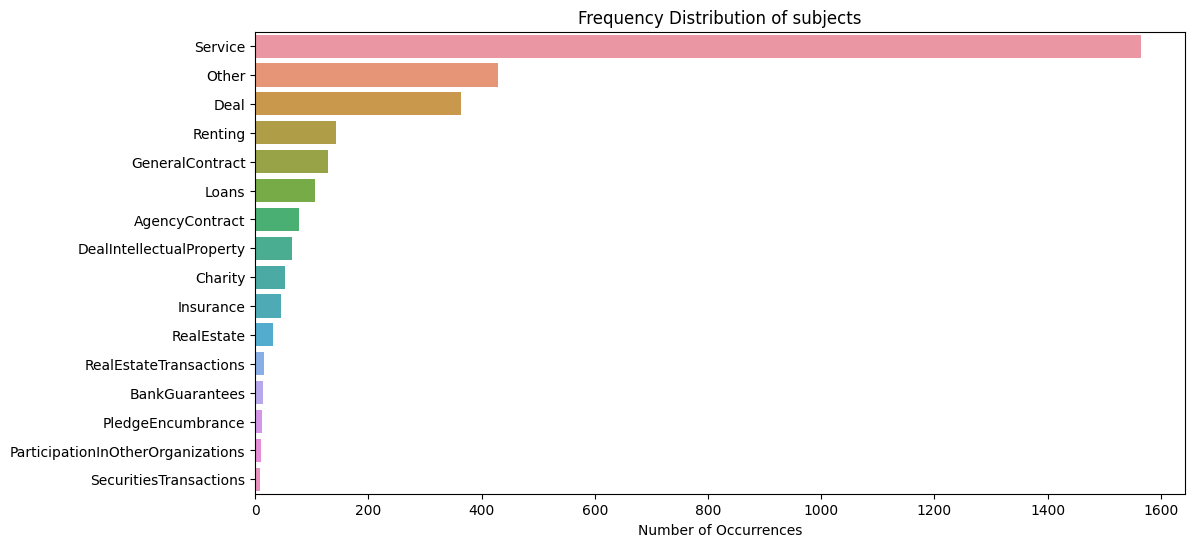

In [40]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 6 ))
sns.barplot(x=cnt.values, y=cnt.index)

print(  cnt )

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


In [41]:
dups_s.index.name = '_id'
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

### 3103 - Всего новых документов в обучающем наборе на 2023-01-30 11:02:49.897000+00:00

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
6340244c9d08c565cfa12341,db,bc7d70a32aed6af4ef6c7752a1b7674d,3.0.0,2023-01-31 18:37:33.526517,6740.0,2022-10-07 16:09:15.340000+00:00,2.000000e+09,21.416413,909.0,RUB,...,2022-10-07 13:43:21.470000+00:00,True,AGREEMENT,130.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6340...,False,3.545353e-01,1.648029e+18,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.465962e-01,-8.198047e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-06 11:13:01.260685,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.507901e-01,8.544303e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-06 11:12:57.718593,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,-2.908297e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.155858e+00,-1.265539e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb3b97e00881c332b5672a7,db,cb42faac316b74abe50fd9a1ae5f4149,2.4.4,2023-01-31 18:37:44.955702,430.0,2021-07-30 15:12:59.254000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,-6.797111e+18,9.0
6285f51af098f73e14297e43,db,1383512495cf9d32e91a34145a27cf0f,3.0.0,2023-01-31 18:38:00.159711,190.0,2022-05-19 10:45:22.737000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,True,1.440000e+08,-5.911332e+18,18.0
5fb376e4d8c9df1ed12372a7,db,4fb950c36151bf29c74eea97d9466335,2.5.3,2023-01-31 18:37:59.202858,440.0,2021-10-28 15:44:16.851000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,6.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,6.898036e+18,1.0


In [42]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [43]:
dups_s[dups_s['unseen']]

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
5ec2b8d8665f7603e03b121a,db,74a7be7f14b129ce379aaa0920978a71,1.6.5,2023-01-31 18:32:27.217863,550.0,2020-05-18 16:35:16.047000+00:00,4.900000e+05,13.102163,114.0,RUB,...,NaT,True,CONTRACT,35.0,7.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,True,9.722266e+00,-1.195163e+18,5.0
63c506dce2456d59975e145c,db,88a0bf0e851b84960702680c7972f090,23.01.04,2023-01-31 21:42:43.455407,3630.0,2023-01-16 14:15:20.502000+00:00,4.000000e+06,15.201805,326.0,RUB,...,NaT,True,CONTRACT,95.0,7.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,3.112603e+01,-8.391154e+18,2.0
63c506ace2456d59975e0f9f,db,2ff69a29f2a6f16826a6e68dc6cc1d22,23.01.04,2023-01-31 21:42:49.474166,430.0,2023-01-16 14:43:58.035000+00:00,5.500000e+07,17.822844,172.0,RUB,...,NaT,True,SUPPLEMENTARY_AGREEMENT,10.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,6.753949e+01,-3.770721e+18,1.0
5efe924d777d4b67a92d55b0,file,c056d218b8ae1d56747afd23ac3cf10f,2.0.0,2023-02-06 11:13:09.792844,17580.0,2020-07-03 12:29:32.528000+00:00,1.865870e+08,19.044408,2372.0,RUB,...,NaT,True,CONTRACT,11.0,76.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5efe...,True,7.446948e+01,-7.745958e+18,1.0
63c506c8e2456d59975e125c,db,8b9cc038759514b95b5c84b242ca539f,23.01.04,2023-01-31 21:42:35.639579,1740.0,2023-01-16 13:32:51.323000+00:00,3.950235e+07,17.491871,440.0,RUB,...,NaT,True,CONTRACT,179.0,11.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63c5...,True,7.860541e+01,-8.991215e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb3b97e00881c332b5672a7,db,cb42faac316b74abe50fd9a1ae5f4149,2.4.4,2023-01-31 18:37:44.955702,430.0,2021-07-30 15:12:59.254000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,-6.797111e+18,9.0
6285f51af098f73e14297e43,db,1383512495cf9d32e91a34145a27cf0f,3.0.0,2023-01-31 18:38:00.159711,190.0,2022-05-19 10:45:22.737000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6285...,True,1.440000e+08,-5.911332e+18,18.0
5fb376e4d8c9df1ed12372a7,db,4fb950c36151bf29c74eea97d9466335,2.5.3,2023-01-31 18:37:59.202858,440.0,2021-10-28 15:44:16.851000+00:00,NaN,NaN,NaN,NaN,...,NaT,True,ANNEX,0.0,6.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,6.898036e+18,1.0


# 🤦 Find markup errors

In [154]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType":{ '$in': ["AGREEMENT", "CONTRACT", "SUPPLEMENTARY_AGREEMENT"] }  },      
    {"user.attributes_tree": {"$ne": None}},
#       {'user.updateDate': {'$gt': lastdate}}    
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True, 'state':True, 'parse.documentType':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(5000)

res = list([i for i in res])
# print(res[0])
_s = f"#### Всего документов, которые размечены человеком : {len(res)}"
display(Markdown(_s))

# res[:4]



/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


#### Всего документов, которые размечены человеком : 1154

In [155]:
user_docs_ids  = [i["_id"] for i in res]
print('user_docs_ids', len(user_docs_ids))


user_docs_ids 1154


In [157]:

userdocs = DataFrame()

def get_span_val(jd:DbJsonDoc, tag):
    tm = jd.get_tokens_map_unchaged()
    
    span = tag.get('span', [0,0]) 
    
    if span[1]-span[0]==0:
        return None
    
    quote = tm.text_range(span)
    
    return quote

def add_error(_id, error_message):    
            
    if error_message:
        missing=False
        if len(error_message)==2:
            error_message, missing = error_message
        
        userdocs.at[_id,'errors count'] = userdocs.at[_id,'errors count']+1
        
        if missing==True:
            userdocs.at[_id, 'error missing']=';\n'.join(  [error_message, userdocs.at[_id,'error missing']] )
        else:
            userdocs.at[_id, 'error']=';\n'.join(  [error_message, userdocs.at[_id,'error']] )
        
#--------        

def validate_date(jd:DbJsonDoc, df, i=0) -> str or None:
    tag = jd.get_attributes_tree().get('date', {})
    val = get_span_val(jd, tag)
    
    if not val:
        return
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    df.at[_id,f'Дата'] = val 
       
    
    if '\n' in val:
        return f"Дата содержит перенос строки"
    
    if len(val) > 25:
        return f"Дата слишком длинная"
    
    
def validate_number(jd:DbJsonDoc, df, i=0) -> str or None:
#     span = jd.get_attributes_tree().get('number', {}).get('span', [0,0])
#     val = jd.get_tokens_map_unchaged().text_range(span)
    
    tag = jd.get_attributes_tree().get('number', {})
    span = tag.get('span', [0,0]) 
    val = get_span_val(jd, tag)
    
    if not val:
        return
    
    
    df.at[_id,f'Номер'] = val 
    
    if 'договор' in val.lower():
        return f"Номер содержит слово"
    
    if '\n' in val:
        return f"Номер содержит перенос строки"
       
    if val.strip() !=val:
        return f"Номер содержит пробелы по краям"
    
    if val.strip()=="№":
        return f"Номер не является номером"
    
    if (span[1]-span[0])>5:
        return f"Номер договора какой-то длинный"

#     if val.strip()[0]=="№":
#         return f"Номер содержит знак №"
        
#     if len(val) > 30:
#         return f"Номер слишком длинный"
    
    
def validate_alias(jd:DbJsonDoc, df, i=0) -> str or None:
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Псевдоним {i+1} отсутсвует", True
    
    tag =  orgs[i].get('alias',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Псевдоним {i+1} отсутсвует", True
    
    
    df.at[_id,f'Псевдоним {i+1}'] = val 
    
    if  '«' in val or '»' in val:
        return f"Псевдоним {i+1} содержит кавычки"
    
    if '\n' in val:
        return f"Псевдоним {i+1} содержит перенос строки"
    
    if len(val) > 25:
        return f"Псевдоним {i+1} слишком длинный"
    
    
def validate_org_name(jd:DbJsonDoc, df, i=0) -> str or None:
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Наименование {i+1} отсутсвует", True
    
    tag = orgs[i].get('name',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Наименование {i+1} отсутсвует", True
    
    df.at[_id,f'Наименование {i+1}'] = val 
    
    if '\n' in val:
        return f"Наименование {i+1} содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Наименование {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Наименование {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Наименование {i+1} содержит кавычки"
    
    
def validate_org_type(jd:DbJsonDoc, df, i=0) -> str or None:
    
    orgs=jd.get_attributes_tree().get('orgs', [{},{}])
    
    if len(orgs) < i+1:
        return f"Форма собственности {i+1} отсутсвует", True
    
    tag = orgs[i].get('type',{})
    val = get_span_val(jd, tag)
    
    if not val:
        return f"Форма собственности {i+1} отсутсвует", True
    
    df.at[_id, f'Форма собственности {i+1}'] = val 
    
    if '\n' in val:
        return f"Форма собственности {i+1}: содержит перенос строки"
    
    if '«' in val:
        if '»' not in val:
            return f"Форма собственности {i+1}: кавычка не закрыта"
    
    if '»' in val:
        if '«' not in val:
            return f"Форма собственности {i+1}: кавычка не открыта"
        
    if val[0]=='«':
        return f"Форма собственности {i+1}: содержит кавычки"
    

def validate_subject_len(jd:DbJsonDoc, df) -> str or None:    
    
    tag = jd.get_attributes_tree().get('subject', {})
    val = get_span_val(jd, tag)
    span = tag.get('span', [0,0]) 
    
    kind = tag.get('value', None) 
    
    
    subject_len = span[1]-span[0]
    
    df.at[_id,'subject len'] = subject_len
    df.at[_id,'subject kind'] = kind
    
    if subject_len > 150:
        df.at[_id,'subject'] = val[:200]
        return f"предмет договора слишком длинный: {subject_len} слов"
    
    if subject_len ==0:
        return f"раздел о предмете договора не указан; определен как [{kind}]"
    
    
def validate_price(jd:DbJsonDoc, df) -> str or None:    
    
    tag = jd.get_attributes_tree().get('price', {})
    
    
    span = tag.get('span', [0,0]) 
        
    _len = span[1]-span[0]
    
#     df.at[_id,'subject len'] = subject_len

    
    
    if not tag:
        return 
    
    price_q = get_span_val(jd, tag)
    df.at[_id,'сумма'] = f"{price_q}"
    
    
    sentence_span1 = jd.get_tokens_map_unchaged().sentence_at_index( span[0])
    sentence_span2 = jd.get_tokens_map_unchaged().sentence_at_index( span[1])
    sentence_span = [ sentence_span1[0], sentence_span2[1]]
    
    
    sentence = jd.get_tokens_map_unchaged().text_range(sentence_span)
    
    amount_name = 'сумма (старая)'
    price_name = 'сумма договора'
    
    
    vat = tag.get('vat')    
    if vat:
        val = get_span_val(jd, vat)    
        df.at[_id, 'налог'] = f'{val}'
        
    vat_unit = tag.get('vat_unit')    
    if vat_unit:
        val = get_span_val(jd, vat_unit)    
        df.at[_id,'vat_unit'] = f'{val}'
        

        
    
    amount_netto = tag.get('amount_netto')    
    if amount_netto:
        val = get_span_val(jd, amount_netto)    
        df.at[_id,'сумма без налога'] = f'{val}'
        
    amount = tag.get('amount')  
    
    if amount:
        val = get_span_val(jd, amount)    
        df.at[_id, amount_name] = f'{val}'
     
        
    amount_brutto = tag.get('amount_brutto')    
    if amount_brutto:
        val = get_span_val(jd, amount_brutto)    
        df.at[_id,'сумма с налогом'] = f'{val}'
        
    currency = tag.get('currency')    
    if currency:
        val = get_span_val(jd, currency)    
        df.at[_id,'currency'] = f'{val}'
        
    
    if vat:
        val = get_span_val(jd, vat)    
        if not val[0].isdigit():
            return  f"налог начинается не с цифры"
     
    #----
    if amount_netto:
        _span = amount_netto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма без налога слишком длинная, должна содержать только число"
    
    #----
    if amount_brutto:
        _span = amount_brutto.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"сумма c налогом слишком длинная, должна содержать только число"
        
    #----
    if amount:
        _span = amount.get('span', [0,0])         
        if _span[1]-_span[0] > 4:
            return  f"{amount_name} слишком длинная, должна содержать только число"
    
    
    if amount_netto or amount_brutto:
        if not vat:
            return  f"налог не указан"
    

    if ' штраф ' in sentence.lower() or "страховая сумма " in sentence.lower() or " пени " in sentence.lower() : 
        print('sentence_span', sentence_span, jd.get_tokens_map_unchaged().text_range(sentence_span))
        return  f"сумма вообще не та!!"
        
    if 'ндс' in sentence.lower():
        if not vat:
            return  f"налог не указан"
        
        if not (amount_netto or  amount_brutto):
            return  f"сумма с учетом налога не указана"
        
    if amount_netto or amount_brutto or amount:
        if not currency:
            return  f"валюта не указана"
        
    if vat:
        if not vat_unit:
            return  f"валюта налога не указана"
    
    if tag:
        if not (price_q.strip()[0].isalpha() or price_q.strip()[0].isdigit):
            return  f"раздел о цене начинается не со слова"
        
    if _len > 150:
        return f"{price_name} слишком длинная: {_len} слов"
    
    if _len < 10:
        return f"{price_name} слишком короткая: {_len} слов, нужно: {sentence_span1[1]- sentence_span2[0]}"

####################################### sentence_at_index

for k, oid in enumerate(user_docs_ids):
# for k, oid in enumerate(['5fe34f64b770574a005553e6']):    
    _id = str(oid)
    oid = ObjectId(_id)
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
        
    attr_tree = jd.get_attributes_tree()  
#     print('',attr_tree)

    
    userdocs.at[_id,'дата редактирования'] = jd.user['updateDate']
    userdocs.at[_id,'link'] = f'https://gpn-audit.nemosoft.ru/#/audit/edit/{_id}'
    userdocs.at[_id,'error'] = ''
    userdocs.at[_id,'error missing'] = ''
    userdocs.at[_id,'errors count'] = 0

    
    
    if not jd.analysis:
        userdocs.at[_id, 'error'] = "Не анализирован!!"
    
    else:
        add_error(_id, validate_subject_len(jd, userdocs) )
        

        add_error(_id, validate_org_type(jd, userdocs, 0) )
        add_error(_id, validate_org_name(jd, userdocs, 0) )
        add_error(_id, validate_alias(jd, userdocs, 0) )
        
        add_error(_id, validate_org_type(jd, userdocs, 1) )
        add_error(_id, validate_org_name(jd, userdocs, 1) )
        add_error(_id, validate_alias(jd, userdocs, 1) )

        add_error(_id, validate_date(jd, userdocs) )
        add_error(_id, validate_number(jd, userdocs) )
        
        add_error(_id, validate_price(jd, userdocs) )
    
    
userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)   

_s = f"#### Всего ошибок: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs)} на документ)"
display(Markdown(_s))

userdocs

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


sentence_span [10328, 10403] 1.11 .Поставщик может уступить право требования по настоящему Договору лишь после получения письменного согласия Покупателя. Письменное согласие Покупателя оформляется путем подписания со стороны Покупателя Уведомления об уступке прав требования. В случае оформления уступки права требования по настоящему Договору Поставщик без наличия письменного согласия Покупателя, последний вправе не согласиться с совершенной уступкой и взыскать с Поставщика штраф в размере 100000 (сто тысяч) рублей за каждый случай уступки права требования.

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек

sentence_span [780, 803] 3.2. Общая страховая сумма по настоящему Договору составляет 296250000 (Двести девяносто шесть миллионов двести пятьдесят тысяч) рублей 00 копеек



#### Всего ошибок: 1297.0 в 1154 документах -- (1.1239168110918545 на документ)

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,сумма с налогом,налог,vat_unit,subject
6152e3af8558145da68d8790,2023-02-01 14:53:58.672,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\nНомер не является номером;\n,Наименование 2 отсутсвует;\nФорма собственност...,6.0,56.0,Service,NaN,NaN,Заказчик,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
6152e3798558145da68d8788,2021-09-30 08:13:06.705,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,6.0,42.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6285f525f098f73e14297f93,2022-10-25 11:16:59.890,https://gpn-audit.nemosoft.ru/#/audit/edit/628...,Наименование 2: кавычка не закрыта;\nНаименова...,Форма собственности 2 отсутсвует;\nФорма собст...,5.0,0.0,None,NaN,Издательско-полиграфическое предприятие «Масте...,Покупатель,...,«20» августа 2020,NaN,NaN,NaN,№ 36/09-2020,NaN,NaN,NaN,NaN,NaN
615ac8b28f3b0514f3f423f2,2021-10-04 09:27:25.636,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Псевдоним 2 отсутсвует;\nФорма собственности 2...,5.0,48.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615ac8cf8f3b0514f3f423f8,2021-10-04 09:30:37.752,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,Номер не является номером;\n,Псевдоним 2 отсутсвует;\nПсевдоним 1 отсутсвуе...,5.0,37.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638085656a07f3e980b2c0f3,2022-11-29 11:44:32.030,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,58.0,Service,Общество с ограниченной ответственностью,Кен,ЗАКАЗЧИК,...,«13» августа 2021,4.1. Общая стоимость услуг по Договору являетс...,NaN,рублей,№ ___,"73665,40","–888398,48","733,08",рублей,NaN
6380855e6a07f3e980b2c0a4,2022-11-29 10:28:08.643,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,75.0,GeneralContract,Общество с ограниченной ответственностью,Кен,Подрядчик,...,«03» сентября 2021,3.1. Общая стоимость Договора (Договорная цена...,NaN,рублей,№ П-520/2021,NaN,"930787, 52","797, 92",рублей,NaN
5fca2aad9083b679224c7606,2020-12-09 15:05:30.896,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,85.0,AgencyContract,ООО,Газпромнефть-Оренбург,Принципал,...,«30» июня 2020,NaN,NaN,NaN,№ 20/20000/01201,NaN,NaN,NaN,NaN,NaN
6380855d6a07f3e980b2c07b,2022-11-29 14:09:37.839,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,60.0,Service,ООО,Протеин,Исполнитель,...,«11» мая 2021,4.1. Общая стоимость услуг Исполнителя составл...,NaN,рублей,NaN,NaN,"84000,00","14000,00",рублей,NaN


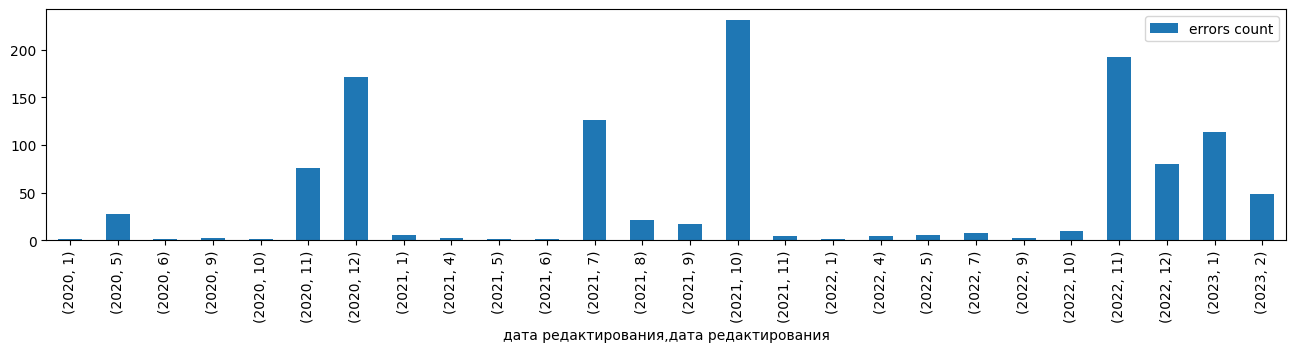

In [142]:
# userdocs.groupby(userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month) [['errors count','дата редактирования']] .count().plot(kind="bar")
import matplotlib.pyplot as plt


ax = userdocs.groupby(
    [userdocs["дата редактирования"].dt.year, userdocs["дата редактирования"].dt.month ])[
        ['errors count']].count().plot(kind="bar", figsize=(16,3))

plt.show()

In [143]:
userdocsBak = userdocs.copy()

In [144]:
from collections import Counter


l = list(userdocs['vat_unit'].values) + list( userdocs['currency'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_currency=[]
for k in c:
    if c[k] < 2:
        rare_currency.append(k)
        

l = list(userdocs['Псевдоним 1'].values) + list( userdocs['Псевдоним 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_aliases=[]
for k in c:
    if c[k] < 2:
        rare_aliases.append(k)
# rare_aliases


l = list(userdocs['Форма собственности 1'].values) + list( userdocs['Форма собственности 2'].values)
l= [str(k).lower() for k in l]
c = Counter(l)
rare_forms=[]
for k in c:
    if c[k] < 2:
        rare_forms.append(k)
# print(rare_forms)        
        
    
    
for i, row in userdocs.iterrows():
    fs1 = str(row['Форма собственности 1']).lower()
    fs2 = str(row['Форма собственности 2']).lower()
    
    as1 = str(row['Псевдоним 1']).lower()
    as2 = str(row['Псевдоним 2']).lower()
    
    
    cs1 = str(row['vat_unit']).lower()
    if cs1 in rare_currency:
        print(i, f'[{cs1}]')
        add_error(i, "Валюта налога очень странная" )
        
    cs2 = str(row['currency']).lower()
    if cs2 in rare_currency:
        print(i, f'[{cs2}]')
        add_error(i, "Валюта очень странная" )
    
    if fs1 in rare_forms:
        print(i, f'[{fs1}]')
        add_error(i, "Форма собственности 1 очень странная" )
    if fs2 in rare_forms:
        print(i, f'[{fs2}]')
        add_error(i, "Форма собственности 2 очень странная" )
        
    if as1 in rare_aliases:
        print(i, f'[{as1}]')
        add_error(i, "Псевдоним 1 очень странный" )
    if as2 in rare_aliases:
        print(i, f'[{as2}]')
        add_error(i, "Псевдоним 2 очень странный" )
        
userdocs

5fe4821ab770574a00555656 [ооо «]
612de89f4f22ff1b7e02fcd7 [eur]
5fb3d4a078df3635f5441c32 [муниципальное автономное учреждение культуры]
6340244c9d08c565cfa12341 [«кредитор»]
6340244c9d08c565cfa12341 [«заемщик»]
6380855c6a07f3e980b2c061 [ооо «ромашка»]
5fdb2144542ce403c92b45c8 [территориальная]
5fb3d79e78df3635f5441d1e [общество с ограниченной ответе венностью]
5fe4821ab770574a00555657 [общественная организация «спортивная общественная организация]
6380858a6a07f3e980b2c4aa [исполнитель или подрядчик]
638085706a07f3e980b2c1ed [акционерное общество (ао )]
638085706a07f3e980b2c1f5 [общество с отграниченной ответственностью (ооо )]
5fca2aab9083b679224c75e7 [газпромнефть-оренбург]
62d149484ae369b4976e31ff [долларов сша]
62d149474ae369b4976e31fc [«застройщик»]
62d149474ae369b4976e31fc [«генеральный подрядчик»]
5fe4821eb770574a00555708 [общественная организация]
5fe48218b770574a005555c6 [муниципальное унитарное предприятие]
5fdb2143542ce403c92b45a1 [зарегистрированный кандидат в депутаты]
6380

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,Дата,сумма,сумма (старая),currency,Номер,сумма без налога,сумма с налогом,налог,vat_unit,subject
6152e5cc8558145da68d8797,2021-10-01 12:23:59.659,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,6.0,76.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6152e3af8558145da68d8790,2023-02-01 14:53:58.672,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,налог не указан;\nНомер не является номером;\n,Наименование 2 отсутсвует;\nФорма собственност...,6.0,56.0,Service,NaN,NaN,Заказчик,...,NaN,"Общая стоимость услуг по Договору составляет, ...",NaN,NaN,№,NaN,NaN,NaN,NaN,NaN
6152e3798558145da68d8788,2021-09-30 08:13:06.705,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Псевдоним 2 отсутсвует;\nНаименование 2 отсутс...,6.0,42.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6285f525f098f73e14297f93,2022-10-25 11:16:59.890,https://gpn-audit.nemosoft.ru/#/audit/edit/628...,Наименование 2: кавычка не закрыта;\nНаименова...,Форма собственности 2 отсутсвует;\nФорма собст...,5.0,0.0,None,NaN,Издательско-полиграфическое предприятие «Масте...,Покупатель,...,«20» августа 2020,NaN,NaN,NaN,№ 36/09-2020,NaN,NaN,NaN,NaN,NaN
615ac8b28f3b0514f3f423f2,2021-10-04 09:27:25.636,https://gpn-audit.nemosoft.ru/#/audit/edit/615...,,Псевдоним 2 отсутсвует;\nФорма собственности 2...,5.0,48.0,Service,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fca2ab09083b679224c762b,2020-12-09 14:59:38.436,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,41.0,Deal,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Покупатель,...,«28» июля 2020,NaN,NaN,NaN,Д_73273_64025_42363,NaN,NaN,NaN,NaN,NaN
6380856e6a07f3e980b2c1b5,2022-11-29 13:54:10.061,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,36.0,Deal,ПАО,Газпром нефть,Поставщик,...,«31» мая 2021,NaN,NaN,NaN,№ 2121187367512542874000000,NaN,NaN,NaN,NaN,NaN
5fca2aad9083b679224c7606,2020-12-09 15:05:30.896,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,,,0.0,85.0,AgencyContract,ООО,Газпромнефть-Оренбург,Принципал,...,«30» июня 2020,NaN,NaN,NaN,№ 20/20000/01201,NaN,NaN,NaN,NaN,NaN
638085686a07f3e980b2c11f,2022-11-29 14:00:00.986,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,,,0.0,82.0,Service,Общество с ограниченной ответственностью,Кен,ЗАКАЗЧИК,...,25-05-2021,3.1 Стоимость Услуг по Договору (Договорная це...,NaN,рублей,№ ГНЯ-21/11040/,NaN,832000,972000,рублей,NaN


In [145]:

userdocs=userdocs.sort_values(["errors count"], ascending=False)
userdocs.to_csv("errors.csv", index=True)     
# userdocs



In [146]:
userdocs_subj = userdocs[ ['subject kind', 'Псевдоним 1', 'Псевдоним 2']]
# userdocs_subj

def get_alias_pair(v):
    return ' -vs- '.join(   np.sort( list([ str(v['Псевдоним 1']).lower(), str(v['Псевдоним 2']).lower()])) ) 


 
c=Counter([get_alias_pair(v) for i, v in userdocs_subj.iterrows()])
rare_aliases_pairs=[k for k in c if c[k] < 2]
for i, row in userdocs.iterrows():
    d=get_alias_pair(row)
    if d in rare_aliases_pairs:
        print(i, f'[{d}]')
        userdocs.at[i, 'strange alias combo'] =f"Необычная пара псевдонимов: {d}"
        
print('-'*20)
del rare_aliases_pairs
# # rare_aliases_pairs
        
# del d
    
def get_alias_subject_pair(v, i):
    return ' / '.join(    list([ str(v[f'Псевдоним {i}']).lower(), str(v['subject kind']).lower()])) 
    
p1 = [get_alias_subject_pair(v, 1) for i, v in userdocs_subj.iterrows()]


c=Counter(p1+[get_alias_subject_pair(v, 2) for i, v in userdocs_subj.iterrows()])
rare_alias_subj_pairs=[k for k in c if c[k] < 3]

for i, row in userdocs.iterrows():
    d1 = get_alias_subject_pair(row, 1)
    d2 = get_alias_subject_pair(row, 2)
    
    if d1 in rare_alias_subj_pairs:
        print(i, f'[{d1}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d1}"
    
    if d2 in rare_alias_subj_pairs :
        print(i, f'[{d2}]')
        userdocs.at[i, 'strange alias-subject'] =f"Необычная пара псевдоним-предмет: {d2}"
        
print('-'*20)        
rare_alias_subj_pairs


612de89f4f22ff1b7e02fcd7 [nan -vs- покупатель]
6340244c9d08c565cfa12341 [«заемщик» -vs- «кредитор»]
62d149474ae369b4976e31fc [«генеральный подрядчик» -vs- «застройщик»]
638085766a07f3e980b2c280 [клиент -vs- перевозчик]
5fca2ab09083b679224c7638 [заказии -vs- исполнитель]
6380855c6a07f3e980b2c061 [клуб -vs- ооо «ромашка»]
6294ae67df54d406a99b1631 [водопользователь -vs- уполномоченный орган]
5ec2b8da665f7603e03b1255 [sun -vs- гпн]
63a43056beaa9eeec65ecafb [nan -vs- заемщик]
62c54895e599c73b751b7974 [nan -vs- клуб]
63c506c9e2456d59975e1277 [ооо -vs- правительство]
635fa420bf4cb23cbb39282f [жертвователь -vs- жертвополучатель]
5fbbe46da2b4551c06107c68 [потребитель -vs- теплоснабжающая организация]
6380858a6a07f3e980b2c4aa [заказчик -vs- исполнитель или подрядчик]
63ce49f8e83d1ee490f3f21c [банк -vs- приказодатель]
63908ca4a1bded13e629f2ea [nan -vs- гарант]
635fa420bf4cb23cbb39282d [жертвователь -vs- жертвонол уча гель]
635fa41fbf4cb23cbb39282c [nan -vs- плательщик]
62bdad696e75fae95cce25eb [з

['«кредитор» / loans',
 '«застройщик» / generalcontract',
 'заказии / service',
 'ооо «ромашка» / service',
 'водопользователь / none',
 'гпн / service',
 'nan / loans',
 'nan / other',
 'ооо / deal',
 'потребитель / deal',
 'поставщик / generalcontract',
 'ссудополучатель / none',
 'страхователь / none',
 'продавец / loans',
 'ссудополучатель / charity',
 'плательщик / charity',
 'заявитель / service',
 'сторона / service',
 'сторона-1 / dealintellectualproperty',
 'предприятие / service',
 'пользователь / dealintellectualproperty',
 'nan / renting',
 'арендодатель / none',
 'поставщик / realestate',
 'заказчик / renting',
 'генподрядчик / service',
 'энергоснабжающая организация / service',
 'подрядчик / deal',
 'абонент / deal',
 'рекламораспространитель / generalcontract',
 'вещатель / deal',
 'клиент^ / service',
 'подписчик / service',
 'спонсор / charity',
 'экспедитор / service',
 'покупатель / renting',
 'арендатор / none',
 'правообладатель / deal',
 'клиент / agencycontract'

In [147]:
_s = f"#### {datetime.today().strftime('%d.%m.%Y')} *Всего* ошибок, недочетов и проч.: {userdocs['errors count'].sum()} в {len(userdocs)} документах -- ({userdocs['errors count'].sum()/len(userdocs):0.2f} на документ)"
display(Markdown(_s))

#### 06.02.2023 *Всего* ошибок, недочетов и проч.: 1433.0 в 1154 документах -- (1.24 на документ)

In [148]:
userdocs_subj = userdocs[ ['link','subject kind', 'Псевдоним 1', 'Псевдоним 2', 'strange alias combo', 'strange alias-subject' ]]

errors_subjects = userdocs_subj[userdocs_subj['strange alias combo'].notnull() | userdocs_subj['strange alias-subject'].notnull() ]
errors_subjects.to_csv("errors_subjects.csv", index=True)         
errors_subjects

,link,subject kind,Псевдоним 1,Псевдоним 2,strange alias combo,strange alias-subject
612de89f4f22ff1b7e02fcd7,https://gpn-audit.nemosoft.ru/#/audit/edit/612...,Deal,ПОКУПАТЕЛЬ,NaN,Необычная пара псевдонимов: nan -vs- покупатель,Необычная пара псевдоним-предмет: nan / deal
6340244c9d08c565cfa12341,https://gpn-audit.nemosoft.ru/#/audit/edit/634...,Loans,«Кредитор»,«Заемщик»,Необычная пара псевдонимов: «заемщик» -vs- «кр...,Необычная пара псевдоним-предмет: «заемщик» / ...
62d149474ae369b4976e31fc,https://gpn-audit.nemosoft.ru/#/audit/edit/62d...,GeneralContract,«Застройщик»,«Генеральный подрядчик»,Необычная пара псевдонимов: «генеральный подря...,Необычная пара псевдоним-предмет: «генеральный...
638085766a07f3e980b2c280,https://gpn-audit.nemosoft.ru/#/audit/edit/638...,Service,Клиент,Перевозчик,Необычная пара псевдонимов: клиент -vs- перево...,Необычная пара псевдоним-предмет: перевозчик /...
5fca2ab09083b679224c7638,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,Service,Заказии,Исполнитель,Необычная пара псевдонимов: заказии -vs- испол...,Необычная пара псевдоним-предмет: заказии / se...
...,...,...,...,...,...,...
5fbbe46da2b4551c06107c8d,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,DealIntellectualProperty,Абонент,Поставщик,NaN,Необычная пара псевдоним-предмет: абонент / de...
63be916f6ba909ce9c6bfe5b,https://gpn-audit.nemosoft.ru/#/audit/edit/63b...,BankGuarantees,Клиент,Банк,NaN,Необычная пара псевдоним-предмет: клиент / ban...
5fdb2145542ce403c92b45fc,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,Service,Клиент,Исполнитель,Необычная пара псевдонимов: исполнитель -vs- к...,NaN
5fc63d611d0a1603c7a0c97d,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,Deal,Благотворитель,Благополучатель,NaN,Необычная пара псевдоним-предмет: благополучат...


In [153]:
userdocs[userdocs['errors count']<2]

,дата редактирования,link,error,error missing,errors count,subject len,subject kind,Форма собственности 1,Наименование 1,Псевдоним 1,...,сумма (старая),currency,Номер,сумма без налога,сумма с налогом,налог,vat_unit,subject,strange alias combo,strange alias-subject
5fca2abe9083b679224c76aa,2020-12-10 09:03:55.360,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,налог не указан;\n,,1.0,39.0,Service,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Заказчик,...,237887310,рублей,№ 10-10120-00982-Р,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fbf75c75d05d73d0295fac0,2020-11-26 12:16:53.044,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,налог не указан;\n,,1.0,31.0,GeneralContract,Общество с ограниченной ответственностью,Газпромнефть-Заполярье,Заказчик,...,7819753407,рублей,ГНЗ-19/11028/00192/Р/05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fbbe46da2b4551c06107c93,2020-11-24 07:59:01.301,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,Наименование 1: кавычка не закрыта;\n,,1.0,94.0,Deal,Акционерное общество,«Арктика Медиа,Абонент,...,NaN,NaN,НФ 00ТВ 0000006484,NaN,NaN,NaN,NaN,NaN,NaN,Необычная пара псевдоним-предмет: абонент / deal
5fb674f833c72547b754ff6c,2021-10-29 12:22:33.613,https://gpn-audit.nemosoft.ru/#/audit/edit/5fb...,,Форма собственности 2 отсутсвует;\n,1.0,54.0,Renting,Акционерное общество,Арктика Медиа,Арендодатель,...,NaN,NaN,19-27Д,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fca2aac9083b679224c7605,2020-12-10 09:02:08.201,https://gpn-audit.nemosoft.ru/#/audit/edit/5fc...,Дата слишком длинная;\n,,1.0,86.0,ParticipationInOtherOrganizations,Общество с ограниченной ответственностью,Газпромнефть-Оренбург,Продавец,...,690000000,рублей,78 А Б 6972416,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167d79187f1d9065bb8b94b,2021-10-14 07:21:37.988,https://gpn-audit.nemosoft.ru/#/audit/edit/616...,,,0.0,26.0,Service,Публичное акционерное общество,Газпром нефть,Заказчик,...,NaN,NaN,№ 123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fdb213e542ce403c92b4523,2020-12-18 09:37:15.277,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,,,0.0,53.0,Deal,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город»,Спонсируемый,...,NaN,NaN,№ 19-52Д,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6166de2a87f1d9065bb8b93b,2021-10-13 13:31:51.249,https://gpn-audit.nemosoft.ru/#/audit/edit/616...,,,0.0,39.0,Service,Публичное акционерное общество,Газпром нефть,Заказчик,...,NaN,NaN,№ ____________________________/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5fdb213e542ce403c92b4521,2020-12-18 09:37:43.148,https://gpn-audit.nemosoft.ru/#/audit/edit/5fd...,,,0.0,53.0,Deal,Общество с ограниченной ответственностью,Рекламно-Информационное агентство «Город»,Спонсируемый,...,NaN,NaN,№ 19-51Д,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Make datapoints

In [115]:
work_dir

PosixPath('/root/artem/work')

In [116]:
from analyser.headers_detector import get_tokens_features
from tf_support.embedder_elmo import ElmoEmbedder
from analyser.legal_docs import embedd_tokens
import os

embedder = ElmoEmbedder.get_instance('elmo')  # lazy init

def _dp_fn(doc_id, suffix):
    return os.path.join(work_dir, 'datasets', f'{doc_id}-datapoint-{suffix}.npy')


def save_contract_data_arrays(db_json_doc: DbJsonDoc):
    # TODO: trim long documens according to contract parser

    id_ = db_json_doc.get_id()

    tokens_map: TextMap = db_json_doc.get_tokens_for_embedding()

    # 1) EMBEDDINGS
    print(len(tokens_map))
    embeddings = embedd_tokens(tokens_map,
                               embedder,
                               log_key=f'id={id_} chs={tokens_map.get_checksum()}')

    # 2) TOKEN FEATURES
    token_features: DataFrame = get_tokens_features(db_json_doc.get_tokens_map_unchaged().tokens)

    # 3) SEMANTIC MAP
    semantic_map: DataFrame = get_semantic_map_new(db_json_doc)
    #####
 
    np.save(_dp_fn(id_, 'token_features'), token_features)
    np.save(_dp_fn(id_, 'semantic_map'), semantic_map)
    _embeddings_file = _dp_fn(id_, 'embeddings')
    np.save(_embeddings_file, embeddings)
    print(f'embeddings saved to {_embeddings_file} {embeddings.shape}')

In [117]:
_docs_ids = [str(i) for i in new_docs_ids]
intersection_set = set.intersection(set(list(dups_s.index)), set(_docs_ids)) 
len(intersection_set)
# intersection_set




80

### Trainset fixtures
#### Invalidate long subjects

In [118]:
ids = list(dups_s.index)


ids_of_long_subject_docs=[]

for k, oid in enumerate(ids):

    _id = str(oid)
    iiid= ObjectId(_id)
    
    src = dups_s.loc[_id]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state not in [15,12]:
                print(jd.state, iiid)
            
            stats.at[_id, 'documentType'] = jd.documentType
            dups_s.at[_id, 'documentType'] = jd.documentType
            
            attr_tree = jd.get_attributes_tree()  
            span = attr_tree.get('subject', {}).get('span',[0,0])
            subject_len = span[1]-span[0]
            stats.at[_id, 'subj_len'] = subject_len
            dups_s.at[_id, 'subj_len'] = subject_len            
                
            if span[0]==0:
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
            if subject_len >= 200:
                
                stats.at[_id, 'valid'] = False
                dups_s.at[_id, 'valid'] = False
                
                
                
                ids_of_long_subject_docs.append(oid)
                
                tm = jd.get_tokens_map_unchaged()
                quote = tm.text_range(span)
                print(k, iiid, span, span[1]-span[0])
#                 print('-'*100)
                sentence_span = tm.sentence_at_index(span[0])
                quote2 = tm.text_range(sentence_span)
                print(quote2[:50])
                print('='*100)
stats[stats['documentType']=='CONTRACT']

dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.csv', index=True)

/root/artem/analyser/integration/db.py:13: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


3008 63ce4a28e83d1ee490f3f4b2 [0, 200] 200
ПРИЛОЖЕНИЕ № 4 К КОНТРАКТУ № от ANNEX No. 4. и TO 
3042 63ce4a83e83d1ee490f3f9eb [0, 200] 200
Приложение № 7 к договору № от" "2019 года

3063 63ce4b0ee83d1ee490f400d1 [0, 200] 200
Приложение № 1 от 29-04-2021 год.



#### Fix missing headers

In [119]:
from analyser.legal_docs import LegalDocument, PARAGRAPH_DELIMITER, GenericDocument, Paragraph
from analyser.ml_tools import SemanticTag
from integration.word_document_parser import join_paragraphs


def save_analysis(db_document: DbJsonDoc, doc_dummie: LegalDocument) -> DbJsonDoc:
  documents_collection = get_mongodb_connection()['documents']
  
  _analyse_json_obj: dict = doc_dummie.to_json_obj()
  print("--analyse_json_obj['headers'] len=", len(_analyse_json_obj['headers']))

#   to_save = db_document.as_dict()
#   to_save['headers'] = _analyse_json_obj['headers']

  documents_collection.update_one({'_id': doc_dummie.get_id()}, {'$set': {'analysis.headers': _analyse_json_obj['headers']}})
 
    
  print("updated", doc_dummie.get_id())


def restore_headers (response, oid) :
  doc = join_paragraphs(response, oid)
  return doc
   


def restore_headlines(k,oid):    

    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
            jd = DbJsonDoc(d)
            
            if jd.state in [15,12]:
                if len(jd.analysis.get('headers', [])) > 0:
                    #  all is ok
#                     print(oid)
                    pass
                else:
                     doc_with_paragraphs = restore_headers(jd.parse, iiid)
                     save_analysis(jd,  doc_with_paragraphs)
                     print ('--', k, oid, len(doc_with_paragraphs.paragraphs))

                    
for k, oid in enumerate(ids):
    restore_headlines(k,oid)


In [120]:
# restore_headlines(1,'62d149474ae369b4976e31fc'): 

In [121]:
len(ids_of_long_subject_docs)

3

In [122]:
dups_s

,source,checksum,version,export_date,len,analyze_date,value,value_log1p,value_span,currency,...,user_correction_date,valid,documentType,subj_len,headers,url,unseen,score,hash,dups
_id,,,,,,,,,,,,,,,,,,,,,
6340244c9d08c565cfa12341,db,bc7d70a32aed6af4ef6c7752a1b7674d,3.0.0,2023-01-31 18:37:33.526517,6740.0,2022-10-07 16:09:15.340000+00:00,2.000000e+09,21.416413,909.0,RUB,...,2022-10-07 13:43:21.470000+00:00,True,AGREEMENT,130.0,22.0,http://gpn-audit.nemosoft.ru/#/audit/edit/6340...,False,3.545353e-01,8.475038e+18,1.0
5ec2b8da665f7603e03b1255,db,3187bfac60ea578221c5d9357756c6c1,1.6.5,2023-02-01 17:26:52.044394,5840.0,2020-05-18 17:16:38.114000+00:00,2.523632e+07,17.043795,5674.0,BRL,...,2023-01-27 10:27:22.086000+00:00,True,CONTRACT,79.0,4.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ec2...,False,6.465962e-01,1.600482e+18,1.0
5edbc62eda3678279fbcadf3,file,027a7c30f74ff8ffe684378e9883dd8e,2.0.2,2023-02-05 13:09:05.381133,1370.0,2020-07-18 20:24:58.934000+00:00,2.400000e+04,10.085851,747.0,RUB,...,2020-07-18 12:24:26.280000+00:00,True,CONTRACT,106.0,10.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5edb...,False,6.507901e-01,4.237525e+18,1.0
5ded4e284ddc27bcf92dd6ce,file,9a44591c17d2b8f34dc8f1c3600c8c3a,1.11.2,2023-02-05 13:09:01.777643,460.0,2020-06-12 21:09:19.574000+00:00,5.900000e+05,13.287880,150.0,RUB,...,2020-06-09 00:40:54.752000+00:00,True,CONTRACT,30.0,5.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5ded...,False,7.597030e-01,5.651422e+18,1.0
63ce49f8e83d1ee490f3f21c,db,25d924fc09b7291d964f464f9c3ec8c3,23.1.27.1,2023-02-03 16:19:06.576376,8530.0,2023-01-28 09:34:50.691000+00:00,3.000000e+09,21.821878,337.0,RUB,...,2023-01-28 01:38:49.198000+00:00,True,CONTRACT,53.0,12.0,http://gpn-audit.nemosoft.ru/#/audit/edit/63ce...,False,1.155858e+00,-4.871516e+18,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5fb2796dd8c9df1ed1236da1,db,b733e0ee7d949178ac45254c1d20318b,2.4.4,2023-01-31 18:37:43.648610,130.0,2021-07-23 10:20:47.637000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,2.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,True,1.440000e+08,8.008172e+18,10.0
5fb376e7d8c9df1ed1237344,db,3d0fea955ac3bd7a07c96d0f68a8b491,2.5.3,2023-01-31 18:37:59.243967,210.0,2021-10-28 15:52:29.224000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,1.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb3...,True,1.440000e+08,1.596129e+18,11.0
5fb27c60d8c9df1ed1236ebb,db,a77061e7f6ae850a1c5b0f2d12b9fff3,2.4.4,2023-01-31 18:37:43.782338,120.0,2021-07-23 10:32:28.793000+00:00,NaN,NaN,NaN,NaN,...,NaT,False,ANNEX,0.0,2.0,http://gpn-audit.nemosoft.ru/#/audit/edit/5fb2...,True,1.440000e+08,-5.591959e+18,21.0


In [123]:
stats.to_csv(export_fn, index=True)

In [ ]:


for k, oid in enumerate(ids):
    iiid= ObjectId(oid)
    src = dups_s.loc[oid]['source']
    jd = None
    if src == 'db':
#       if False:
        d = get_doc_by_id(iiid)
        if d is not None:
          jd = DbJsonDoc(d)
    else:
#         if False:
        print(oid, k, 'of', len(ids), src)
        jd = files_dict[iiid]
        
    print(oid, k, 'of', len(ids), src)

    if jd is not None:
        if jd.state in [15,12]:                
            save_contract_data_arrays(jd)


In [ ]:
25